# Week 2 - Function 3 ((16DP, 3D))

# Setup
Let's load all the imports in the top to avoid repeating and simplify the readability of each solution.

In [1]:
import numpy as np

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import norm
from ipywidgets import interact, FloatSlider

from utils.plotting_utils import (
    plot_3D_initial_data,
    plot_output_outliers,
    plot_3D_mean_uncertainty
)

# Plan
Recap we have the following data: ((16, 3)) - 16DP & 3D, that can be found `./data/week_2/function_3/`.

0. Setup:
    1. Load the data
    2. Analyse raw data - visualise data and see patterns
    3. Normalise input & output - this will make it easier to work with the data
    4. Analyse normalise data - verify (visually should look the same)
    5. Early result
1. Build probabilistic Model
2. Acquisition Function


# 0.1. Setup > Load the data

In [2]:
X_train_raw = np.load(r"./data/week_2/function_3/inputs.npy")
y_train_raw = np.load(r"./data/week_2/function_3/outputs.npy")

print(f"Shape: X={X_train_raw.shape}, y={y_train_raw.shape}")
print(f"X range: [{X_train_raw.min():.4f}, {X_train_raw.max():.4f}]")
print(f"y range: [{y_train_raw.min():.2e}, {y_train_raw.max():.2e}]")

Shape: X=(16, 3), y=(16,)
X range: [0.0468, 0.9909]
y range: [-3.99e-01, -3.26e-02]


# 0.2. Setup > Analyse raw data

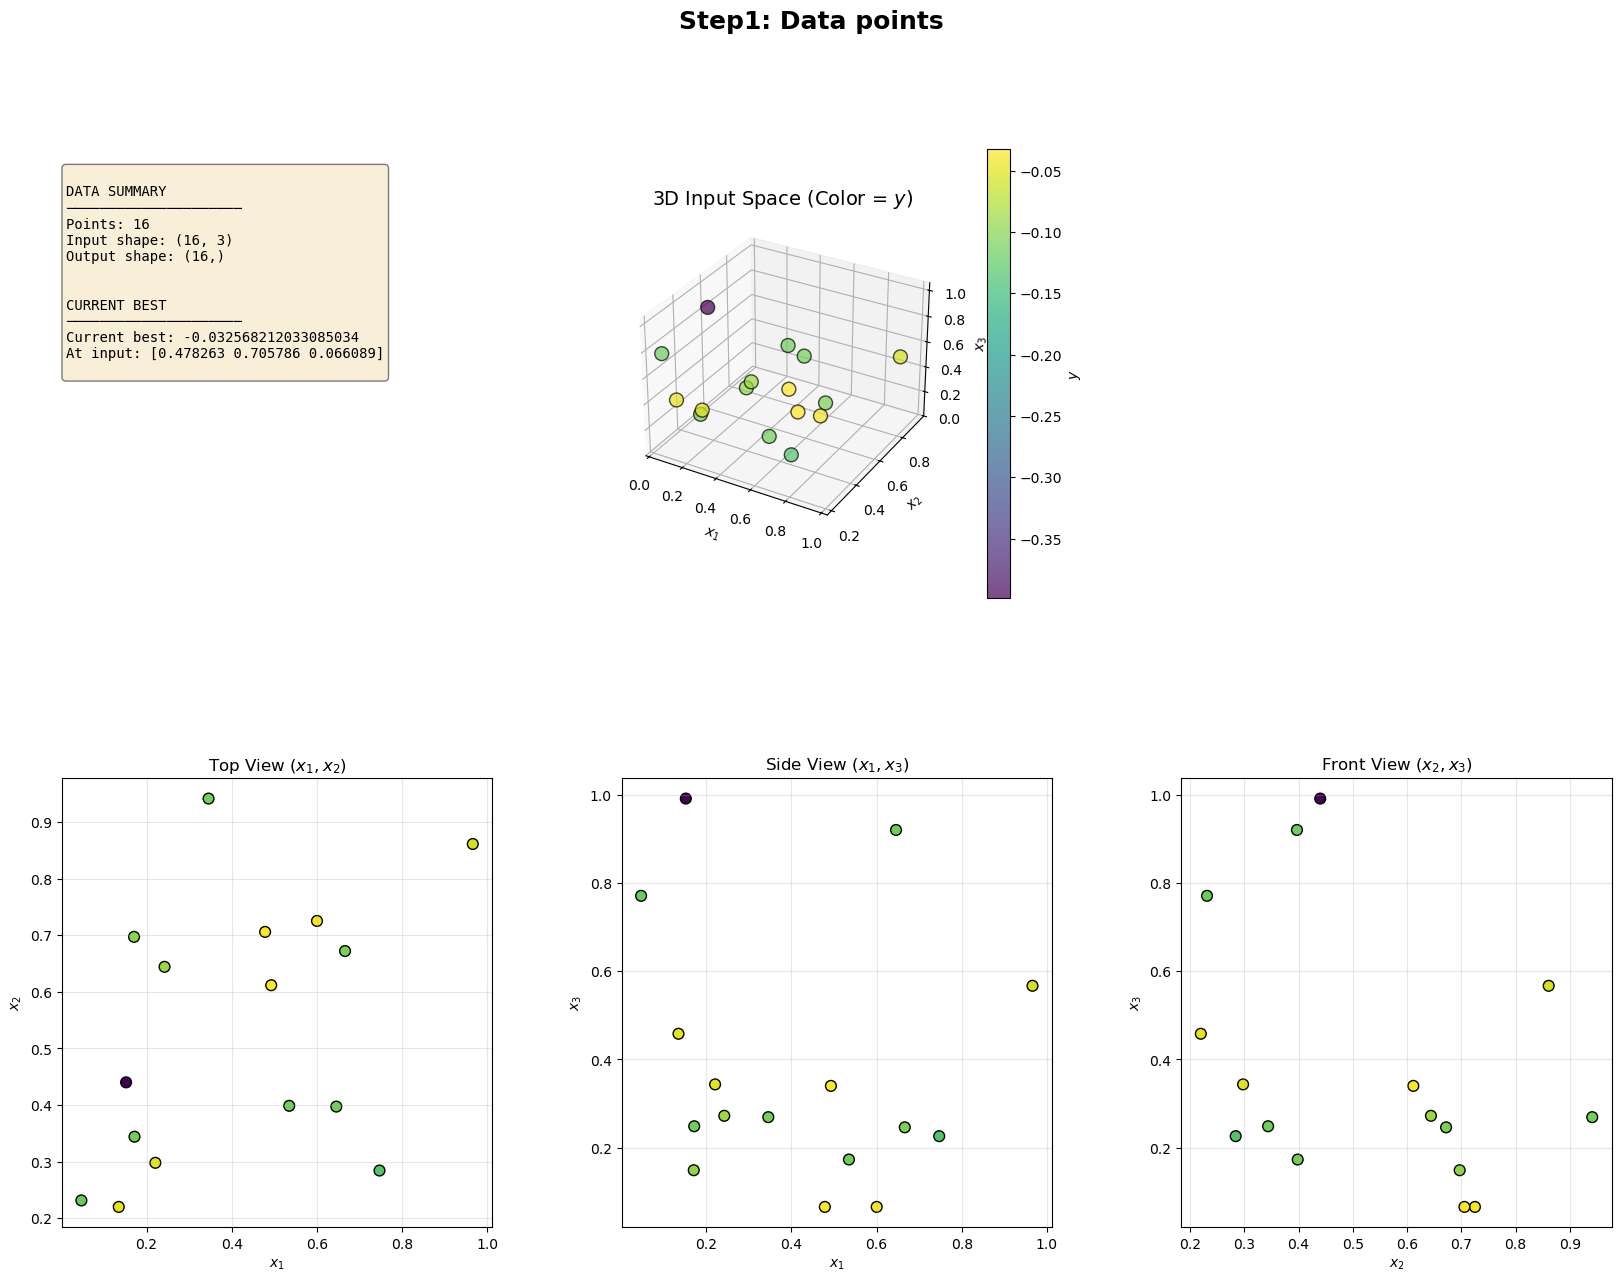

In [15]:
plot_3D_initial_data(X_train_raw, y_train_raw, "Step1: Data points", f"""
DATA SUMMARY
─────────────────────
Points: {len(X_train_raw)}
Input shape: {X_train_raw.shape}
Output shape: {y_train_raw.shape}


CURRENT BEST
─────────────────────
Current best: {np.max(y_train_raw)}
At input: {X_train_raw[np.argmax(y_train_raw)]}
""")

# 0.3. Setup > Normalise the data

In [16]:
# Normalise the data so is easier to visualise + plus needed for BO
# =================================================================
scaler_X = MinMaxScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train_raw)
y_train = scaler_y.fit_transform(y_train_raw.reshape(-1, 1)).ravel()

# 0.4. Setup > Analyse normalise data

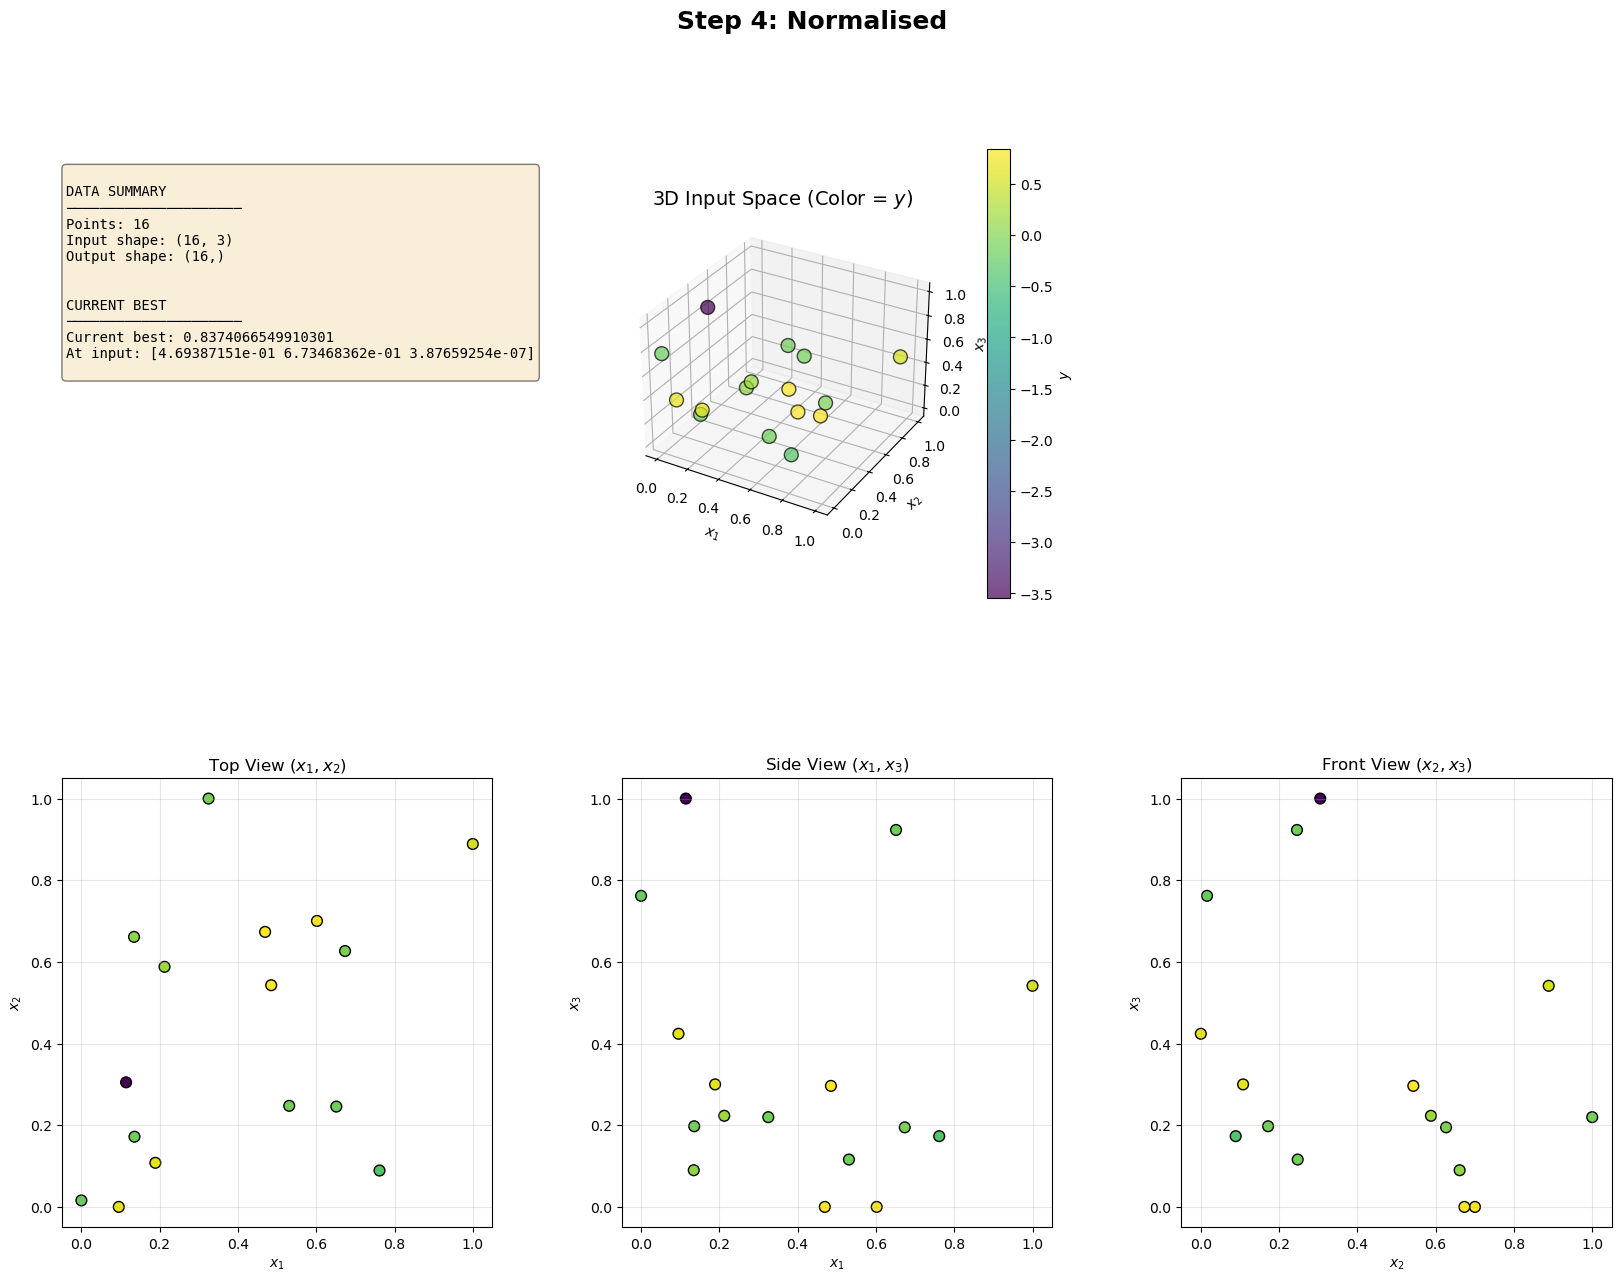

In [17]:
plot_3D_initial_data(X_train, y_train, "Step 4: Normalised", f"""
DATA SUMMARY
─────────────────────
Points: {len(X_train)}
Input shape: {X_train.shape}
Output shape: {y_train.shape}


CURRENT BEST
─────────────────────
Current best: {np.max(y_train)}
At input: {X_train[np.argmax(y_train)]}
""")

# 0.5. Setup > Early result

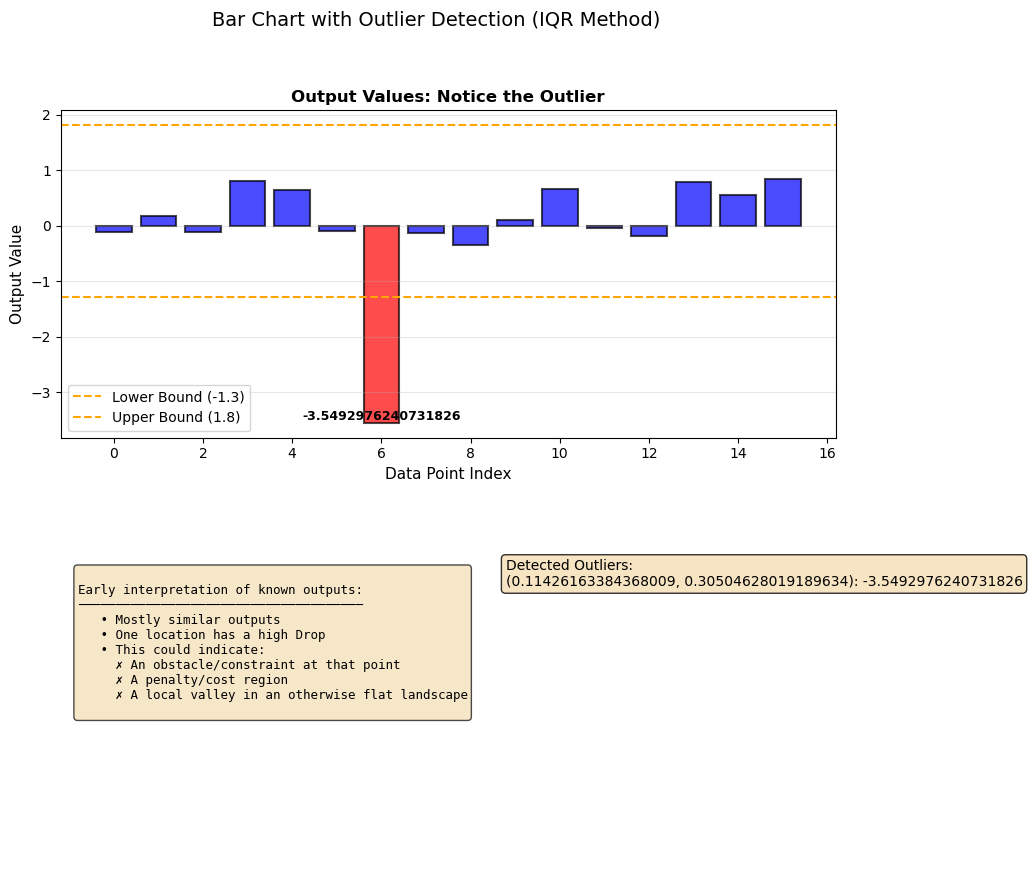

In [18]:
plot_output_outliers(X_train, y_train, "Bar Chart with Outlier Detection (IQR Method)", f"""
Early interpretation of known outputs:
──────────────────────────────────────
   • Mostly similar outputs
   • One location has a high Drop
   • This could indicate:
     ✗ An obstacle/constraint at that point
     ✗ A penalty/cost region
     ✗ A local valley in an otherwise flat landscape
""")

# 1. Build probabilistic Model

From early exploration we know that:
- One sharp drop (penalty zone)
- Sparse data

## Kernel choice
Similar logic as we did in [function 1](./week_1_function_1.ipynb), we will use Matern kernels.

In [19]:
# Step 1: Kernel + Model
# ======================
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * Matern(
    length_scale=1.0,
    nu=1.5,
    length_scale_bounds=(1e-7, 1e2)
)

model = GaussianProcessRegressor(
    kernel=kernel,
    alpha=.5,
    normalize_y=False,
    n_restarts_optimizer=10
)

model.fit(X_train, y_train)
print(f"Optimized Kernel: {model.kernel_}")

#  Create prediction grid
n_grid = 50
x1_range = np.linspace(max(0, X_train[:, 0].min() - 0.5), min(0.999999, X_train[:, 0].max() + 0.5), n_grid)
x2_range = np.linspace(max(0, X_train[:, 1].min() - 0.5), min(0.999999, X_train[:, 1].max() + 0.5), n_grid)
x3_range = np.linspace(max(0, X_train[:, 2].min() - 0.5), min(0.999999, X_train[:, 2].max() + 0.5), n_grid)

X1_test, X2_test, X3_test = np.meshgrid(x1_range, x2_range, x3_range)
X_grid = np.c_[X1_test.ravel(), X2_test.ravel(), X3_test.ravel()]

# Make predictions
mu, sigma = model.predict(X_grid, return_std=True)

# Plot only
X1_2D, X2_2D = np.meshgrid(x1_range, x2_range)
x3_slice = np.median(X_train[:, 2])

interact(lambda x3: plot_3D_mean_uncertainty(
   X_train,
   model,
   X1_2D,
   X2_2D,
   x3
), x3=FloatSlider(
    value=np.mean(X_train[:, 2]),
    min=X_train[:, 2].min(),
    max=X_train[:, 2].max(),
    step=0.1,
    description='X3 Slice:'
))


Optimized Kernel: 0.808**2 * Matern(length_scale=0.324, nu=1.5)


interactive(children=(FloatSlider(value=0.3413252229002086, description='X3 Slice:', max=0.9999999999999999), …

<function __main__.<lambda>(x3)>

# 2. Acquisition function

From early exploration we know that:
- One sharp drop (penalty zone)
- Sparse data
- Low dimension

We want to explore to understand better the shape but we want to avoid exploring the penalty zone.

So I decided to select Expected Improvement (EI), since we can have flexibility for exploration and exploitation, since we don't know much about the function, we will use a bit higher exploration than the balanced one but without being too agressive to avoid the outlier.

In [20]:
def expected_improvement(mu, sigma, y_best, xi=0.1):
    """
    Expected Improvement acquisition function

    EI = E[max(f(x) - f(x_best), 0)]
    
    Parameters:
        mu: Mean predictions from GP
        sigma: Standard deviation from GP
        y_best: Current best observed value (in normalized space)
        xi: Exploration parameter (higher = more exploration)
        
    Returns:
        ei: Expected improvement values
    """
    with np.errstate(divide='warn'):
        improvement = mu - y_best - xi
        Z = improvement / sigma
        ei = improvement * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0
    return ei

y_best_norm = np.max(y_train)

xi = 0.2 # a bit more agressive in this phase to increase exploration

ei_values = expected_improvement(mu, sigma, y_best_norm, xi=xi)

print(f"\nExpected Improvement (EI):")
print(f"  Min: {ei_values.min():.8f}")
print(f"  Max: {ei_values.max():.8f}")
print(f"  Mean: {ei_values.mean():.8f}")

print("\nSTEP 7: Finding best next point to evaluate...")

best_idx = np.argmax(ei_values)
x_next_norm = X_grid[best_idx]
ei_best = ei_values[best_idx]

# Convert to original space
x_next_orig = scaler_X.inverse_transform([x_next_norm])[0]

print(f"\n{'='*80}")
print(f"RECOMMENDED NEXT POINT")
print(f"{'='*80}")
print(f"\nIn original space:")
print(f"  Input 1: {x_next_orig[0]:.6f}")
print(f"  Input 2: {x_next_orig[1]:.6f}")
print(f"  Input 3: {x_next_orig[2]:.6f}")
print(f"\nIn normalized space:")
print(f"  Input 1: {x_next_norm[0]:.6f}")
print(f"  Input 2: {x_next_norm[1]:.6f}")
print(f"  Input 2: {x_next_norm[2]:.6f}")

# Get prediction at this point
y_pred_next, y_std_next = model.predict([x_next_norm], return_std=True)
y_pred_next_orig = scaler_y.inverse_transform([[y_pred_next[0]]])[0, 0]

print(f"\nPredicted output at this point:")
print(f"  Normalized: {y_pred_next[0]:.6f} ± {y_std_next[0]:.6f}")
print(f"  Original: {y_pred_next_orig:.6f}")
print(f"  95% CI: [{y_pred_next_orig - 1.96*y_std_next[0]:.6f}, {y_pred_next_orig + 1.96*y_std_next[0]:.6f}]")

print(f"\nExpected Improvement at this point: {ei_best:.8f}")


Expected Improvement (EI):
  Min: 0.00000000
  Max: 0.04881501
  Mean: 0.01925722

STEP 7: Finding best next point to evaluate...

RECOMMENDED NEXT POINT

In original space:
  Input 1: 0.797164
  Input 2: 0.941359
  Input 3: 0.066089

In normalized space:
  Input 1: 0.816326
  Input 2: 0.999999
  Input 2: 0.000000

Predicted output at this point:
  Normalized: 0.191124 ± 0.750817
  Original: -0.086543
  95% CI: [-1.558145, 1.385059]

Expected Improvement at this point: 0.04881501
